RNNGaussianDyBM timeseries prediction demo
===========================================

- Author: Sakyasingha Dasgupta (sdasgup@jp.ibm.com)

- Date: Sep 27, 2016.
- (C) Copyright IBM Corp. 2016

The RNNGaussianDyBM (RNN-G-DyBM) extends the Gaussian DyBM model by introducing a nonlinear hidden RNN layer. Similar to other DyBM models, the Gaussian DyBM can be trained online for learning the generative model of given time-series patterns, and can be then used to predict future values of the time series. Using the nonlinear RNN layer it can project the original time series input to a high dimensional nonlinear state space, which can be effective in deal with inherent nonlinearities and long temporal memory dependencies.

See `RNNGaussianDyBM module` in docs for mathematical description. 

For further model details see:
[1] S.Dasgupta & T. Osogami, Nonlinear Dynamic Boltzmann Machine for Time-series Prediction (in submission)

Model descriptions and initialization
-------------------------------------
RNN-G-DyBM uses the same memory units as available with the G-DyBM model. 

RNN-G-DyBM can be initialized using the following parameters:

- `in_dim` is the dimension of the input time-series patterns $\mathbf{X}$.

- `out_dim` is the dimension of the expected output time-series patterns

- `rnn_dim` is the dimension of the hidden RNN layer

- `spectral_radius` is the spectral radius of the RNN layer weight matrix

- `sparsity` is the sparsity of the RNN layer weight matrix

- `delay` determines the length of the queue (which will be `delay`-1).

- `decay_rates` is a list of eligibility traces' parameters.

- `leak` is the discount rate of the RNN layer units. 0.0<`leak`<=1.0

- `SGD` decides the type of stochastic gradient descent optimization to use. Options: AdaGrad (default), AdaGradPlus, RMSProp and ADAM.

- `random_seed` fixed the random number generator seed for reproducibility of results

- `L1` specifies the strength of L1 regularization. (defaults to zero)

- `L2` specifies the strength of L1 regularization. (defaults to zero)

- `learning_rate` sets the learning rate of SGD.


Example
-------
In this simple example we use the RNN-G-DyBM to learn to predict the next pattern for of a noisy sine wave with large standard deviatin of noise. This example is similar to Gaussian DybM demo for comparison:


Learning epoch RMSE : 0.38110
Learning epoch RMSE : 0.14297
Learning epoch RMSE : 0.14516
Learning epoch RMSE : 0.14184
Learning epoch RMSE : 0.13765
Learning epoch RMSE : 0.14025
Learning epoch RMSE : 0.13572
Learning epoch RMSE : 0.13575
Learning epoch RMSE : 0.14817
Learning epoch RMSE : 0.14397


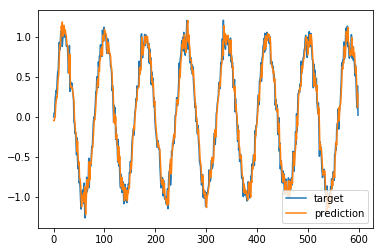

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from pydybm.base.generator import NoisySin
from pydybm.time_series.rnn_gaussian_dybm import RNNGaussianDyBM
from pydybm.base.sgd import RMSProp
from sklearn.metrics import mean_squared_error
import numpy as np

def MSE(y_true,y_pred):
    """
    Function to calculate the mean squared error of a sequence of predicted vectors
    
    y_true : array, shape(L,N)
    y_pred : array, shape(L,N)

    mean of (dy_1^2 + ... + dy_N^2 ) over L pairs of vectors (y_true[i],y_pred[i])
    """
    MSE_each_coordinate = mean_squared_error(y_true,y_pred,multioutput="raw_values")
    return np.sum(MSE_each_coordinate)

def RMSE(y_true,y_pred):
    """
    Function to calculate the root mean squared error of a sequence of predicted vectors
    
    y_true : array, shape(L,N)
    y_pred : array, shape(L,N)

    squared root of the mean of (dy_1^2 + ... + dy_N^2 ) over L pairs of vectors (y_true[i],y_pred[i])
    """
    return np.sqrt(MSE(y_true,y_pred))

# Prepare a generator of noisy sine wave time-series
length = 600  # length of the time-series
period = 80   # period of the sine wave
std = 0.1     # standard deviation of the noise
dim = 1       # dimension of the time-series
timeSeries = NoisySin(length,period,std,dim)


#DyBM initialization parameters
in_dim = 1        # dimension of the input time-series
out_dim = 1       # dimension of the expected output time-series
rnn_dim = 100     # dimension of RNN layer
max_iter = 10     # maximum number of learning epochs/iterations to run
SGD = RMSProp     # setting the SGD optimization method  

#setting RNN-G-DyBM hyperparameters
delay = 2
decay = 0.3
sparsity = 0.1
spectral_radius = 0.95
leak = 1.0
learning_rate = 0.001
random_seed = 2

# Create and initialize a RNN-Gaussian DyBM
model = RNNGaussianDyBM(in_dim,out_dim,rnn_dim,spectral_radius,sparsity,delay=delay,
                        decay_rates =[decay],leak=leak, random_seed = random_seed, SGD=SGD())  
model.set_learning_rate(learning_rate)


#training the RNNGaussian DyBM
for i in range(max_iter):
    #initialize the memory units in DyBM
    model.init_state() 
    #reset the noisey sine wave time series data
    timeSeries.reset(i)
    #learn the time-series patterns and return the predicted and actual data
    result= model.learn(timeSeries, get_result=True)
    #calculate the prediction error
    error = RMSE(result["actual"],result["prediction"])
    print ('Learning epoch RMSE : %.5f' %(error))
    
# Plot the time-series and prediction 

plt.plot(result["actual"],label="target")
plt.plot(result["prediction"],label="prediction")
plt.legend()